In [2]:
import pandas as pd

import sys
print(sys.version)
sys.path.append('../../')
sys.path.append('../')
sys.path.append('../../../')


from drive.model_training.data_utils.extractors import * 
from drive.model_training.data_utils.animate_time_constant import * 
from first_order_model import *

from drive.util.model_func import *
from drive.util.transform_algebra import *



import matplotlib.animation as animation
from matplotlib.backend_bases import KeyEvent

import tqdm
import pickle
import scipy
from matplotlib.backends.backend_pdf import PdfPages


color_dict = {"asphalt":"lightgrey", "ice":"aliceblue","gravel":"papayawhip","grass":"honeydew"}

3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]
3.10.12 (main, Jul 19 2024, 11:05:56) [GCC 11.4.0]


In [3]:
PATH_TO_MODEL_EVALUATION_PARAM  = pathlib.Path('/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/metric/motion_model_prediction_error.pkl')
with open(PATH_TO_MODEL_EVALUATION_PARAM, 'rb') as file:
            model_prediction_metric = pickle.load(file)["MRMSE_2d"]["drive_dataset_warthog_wheels"]

PATH_TO_METRIC_RESULTS  = pathlib.Path('/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/metric/metric_results.pkl')
with open(PATH_TO_METRIC_RESULTS, 'rb') as file:
            diff_metric_res = pickle.load(file)

            kin_metric = diff_metric_res["kinetic_energy"]["drive_dataset_warthog_wheels"]
            kinetic_energy_wheel_encoder = diff_metric_res["kinetic_energy_wheel_encoder"]["drive_dataset_warthog_wheels"]
            kinetic_energy_wheel_encoder_ratio = diff_metric_res["kinetic_energy_wheel_encoder_ratio"]["drive_dataset_warthog_wheels"]
            DiffSpeedProprioExteroEnergy = diff_metric_res["DiffSpeedProprioExteroEnergy"]["drive_dataset_warthog_wheels"]
            
            KineticEnergyICPOnly = diff_metric_res["KineticEnergyICPOnly"]["drive_dataset_warthog_wheels"]
            KineticEnergyWheelOnly = diff_metric_res["KineticEnergyWheelOnly"]["drive_dataset_warthog_wheels"]
            
            print_column_unique_column(kin_metric)
            print_column_unique_column(model_prediction_metric)

__________ Unique columns __________
['dataset_id' 'robot' 'traction' 'max_linear_speed_sampled' 'terrain']
__________________________________

__________Multiple columns__________
['total_energy_metric' 'rotationnal_energy_metric'
 'translationnal_energy_metric' 'cmd_left_wheel' 'cmd_right_wheel']
__________________________________

__________ Unique columns __________
['translation_error' 'rotation_error' 'dataset_id' 'robot' 'traction'
 'max_linear_speed_sampled']
__________________________________

__________Multiple columns__________
['cmd_left_wheel' 'cmd_right_wheel']
__________________________________



______________________________-


/home/nicolassamson/.pyenv/versions/3.10.12/envs/data_analysis/lib/python3.10/site-packages/numpy/_core/_methods.py:185: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


_________________
_________________


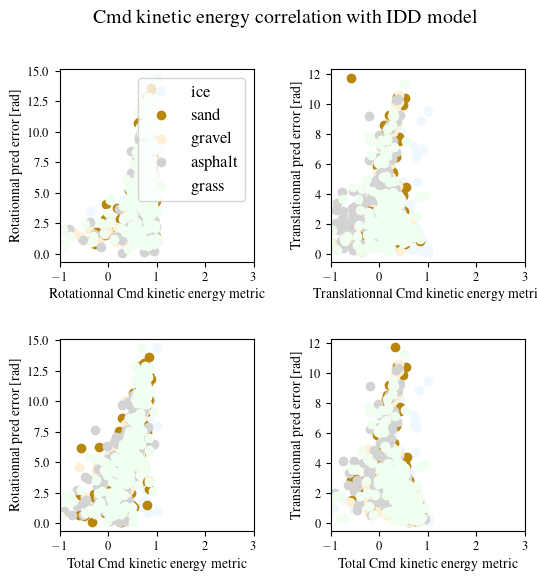

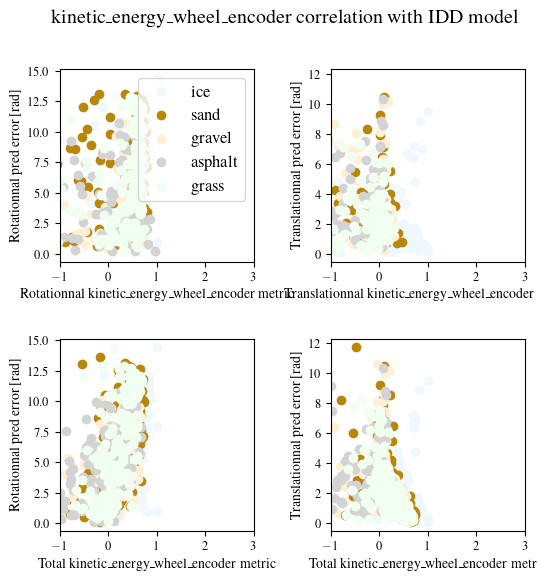

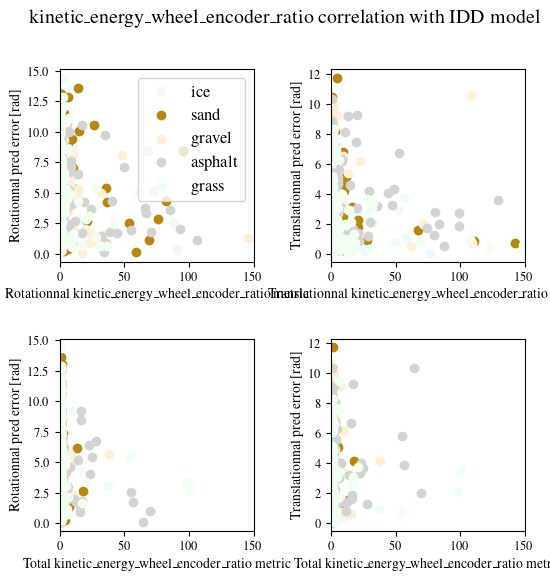

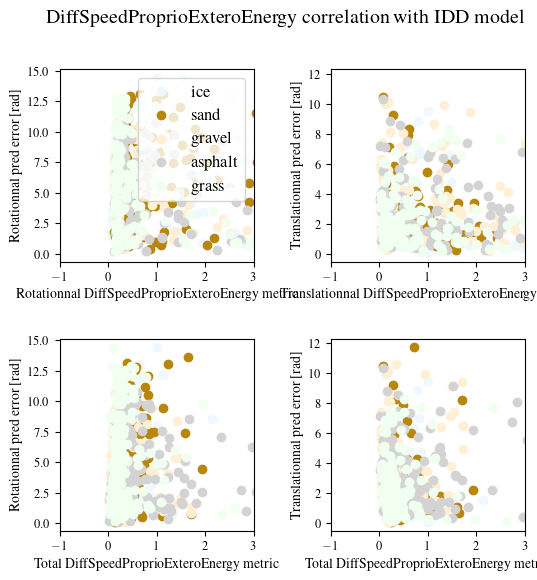

In [ ]:
def scatter_plot_correlation(ax,x,y,x_95,labels,color):

    #ax.errorbar(x,y,xerr=x_95,label=labels[2],color=color)
    ax.scatter(x,y,label=labels[2],color=color)
    
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])

def graph_correlation_error(difficulty_metric, prediction_error,difficulty_metric_name,percentage=False):

    fig, axs = plt.subplots(2,2)

    fig.set_figwidth(6)
    fig.set_figheight(6)
    fig.subplots_adjust(hspace=0.4,wspace=0.4)


    fig.suptitle(f"{difficulty_metric_name} correlation with IDD model")
    color_dict = {"asphalt":"lightgrey", "ice":"aliceblue","gravel":"papayawhip","grass":"honeydew","sand":"darkgoldenrod"}
    list_record = []
    for terrain in list(difficulty_metric.terrain.unique()):
        
        df_diff = difficulty_metric.loc[difficulty_metric.terrain==terrain]
        df_pred_error = prediction_error.loc[difficulty_metric.terrain==terrain]

        rotationnal_diff = np.mean(column_type_extractor(df_diff,"rotationnal_energy_metric"),axis=1)
        translationnal_diff = np.mean(column_type_extractor(df_diff,"translationnal_energy_metric"),axis=1)
        total_energy_diff = np.mean(column_type_extractor(df_diff,"total_energy_metric"),axis=1)

        rotationnal_diff_95 = 2*np.std(column_type_extractor(df_diff,"rotationnal_energy_metric"),axis=1)
        translationnal_diff_95 = 2* np.std(column_type_extractor(df_diff,"translationnal_energy_metric"),axis=1)
        total_energy_diff_95 = 2*np.std(column_type_extractor(df_diff,"total_energy_metric"),axis=1)
        
        terrain_translation_MRMSE_2d = column_type_extractor(df_pred_error,"translation_error")
        terrain_rotation_MRMSE_2d = column_type_extractor(df_pred_error,"rotation_error")

        

        labels = [f"Rotationnal {difficulty_metric_name} metric",
                "Rotationnal pred error [rad]",terrain]
        scatter_plot_correlation(axs[0,0],rotationnal_diff,terrain_rotation_MRMSE_2d,rotationnal_diff_95,labels,color_dict[terrain])

        labels = [f"Total {difficulty_metric_name} metric",
                "Rotationnal pred error [rad]",terrain]
        scatter_plot_correlation(axs[1,0],total_energy_diff,terrain_rotation_MRMSE_2d,total_energy_diff_95,labels,color_dict[terrain])

        labels = [f"Total {difficulty_metric_name} metric",
                "Translationnal pred error [rad]",terrain]
        scatter_plot_correlation(axs[1,1],total_energy_diff,terrain_translation_MRMSE_2d,total_energy_diff_95,labels,color_dict[terrain])

        labels = [f"Translationnal {difficulty_metric_name} metric",
                "Translationnal pred error [rad]",terrain]
        dict_results  = scatter_plot_correlation(axs[0,1],translationnal_diff,terrain_translation_MRMSE_2d,translationnal_diff_95,labels,color_dict[terrain])
        
        dict_results["terrain"] = terrain

        list_record.append(dict_results)

    axs[0,0].legend()
    for ax in np.ravel(axs):
        if percentage:
                ax.set_xlim(0,150)
        else:
             ax.set_xlim(-1,3)

        

def correlation_graph_error(model_prediction_metric, diff_metric_res):


    print_column_unique_column(diff_metric_res)
    print_column_unique_column(model_prediction_metric)
    #correlation_graph_error(model_prediction_metric, diff_metric_res)


graph_correlation_error(kin_metric, model_prediction_metric,"Cmd kinetic energy")
print("______________________________-")
graph_correlation_error(kinetic_energy_wheel_encoder, model_prediction_metric,"kinetic_energy_wheel_encoder")

print("_________________")
graph_correlation_error(kinetic_energy_wheel_encoder_ratio, model_prediction_metric,"kinetic_energy_wheel_encoder_ratio",percentage=True)

print("_________________")
graph_correlation_error(DiffSpeedProprioExteroEnergy, model_prediction_metric,"DiffSpeedProprioExteroEnergy",percentage=False)



(6960,)
(174, 40)
(6960,)
(174, 40)
(6960,)
(174, 40)
(6960,)
(174, 40)
(6960,)
(174, 40)
(6960,)
(174, 40)
0.7862019052348399
m std for ice = [0.00633438]
0.5074551823386892
m std for ice = [0.02658836]
0.12256492867605384
m std for ice = [0.01791013]
(9680,)
(242, 40)
(9680,)
(242, 40)
(9680,)
(242, 40)
(9680,)
(242, 40)
(9680,)
(242, 40)
(9680,)
(242, 40)
0.8804778271774818
m std for sand = [0.00553672]
0.8593519079771177
m std for sand = [0.01909194]
0.5745498497317127
m std for sand = [0.02312152]
(7400,)
(185, 40)
(7400,)
(185, 40)
(7400,)
(185, 40)
(7400,)
(185, 40)
(7400,)
(185, 40)
(7400,)
(185, 40)
0.9367478874407371
m std for gravel = [0.0051323]
0.9427446349148334
m std for gravel = [0.01180893]
0.8266257401647104
m std for gravel = [0.01657546]
(9440,)
(236, 40)
(9440,)
(236, 40)
(9440,)
(236, 40)
(9440,)
(236, 40)
(9440,)
(236, 40)
(9440,)
(236, 40)
0.9023046750614817
m std for asphalt = [0.00690475]
0.8939039209285146
m std for asphalt = [0.0159014]
0.8056503710434184
m 

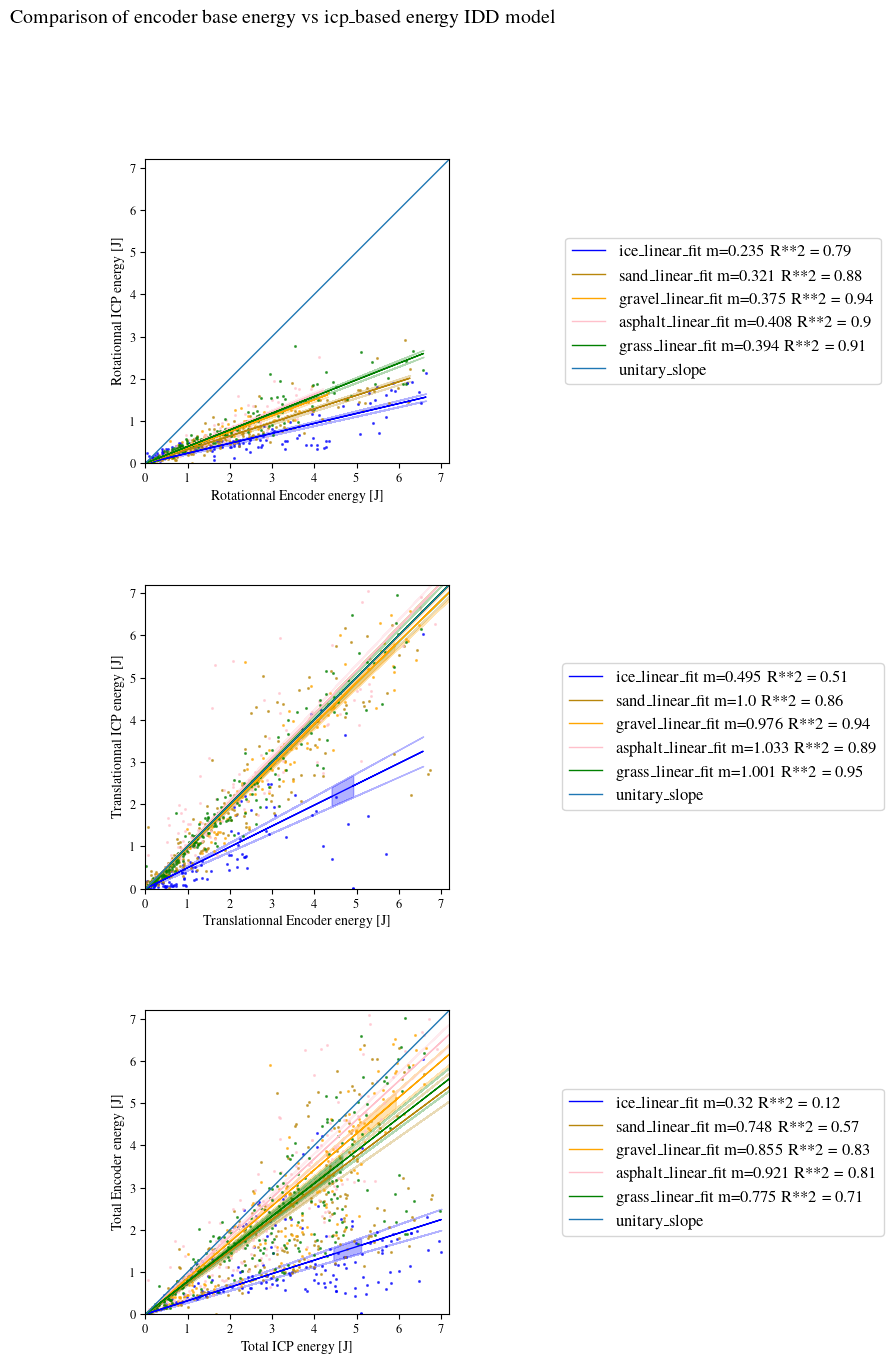

In [20]:

def linear_function(x,m):
    return m*x


def fit_linear_with_0_enforced(translationnal_wheel,translationnal_icp_en):
    popt, pcov = scipy.optimize.curve_fit(linear_function,translationnal_wheel,translationnal_icp_en)

    slope = popt[0]

    prediction = linear_function(translationnal_wheel,slope)
    error_prediction = translationnal_icp_en-prediction

    ss_res = np.sum(error_prediction**2)
    ss_tot = np.sum((translationnal_icp_en - np.mean(translationnal_icp_en))**2)

    r_square = 1- ss_res/ss_tot

    m_std = np.sqrt(pcov[0])
    print(r_square)




    return slope,r_square,m_std




def scatter_plot_correlation_compute_95(ax,x,y,x_95,labels,color):

    #ax.errorbar(x,y,xerr=x_95,label=labels[2],color=color)
    
    diff_abs_icp_based = np.abs(x-y)

    ax.scatter(x,y,color=color,alpha=0.6,s=1.5)
    slope_translation,r_square,std_m = fit_linear_with_0_enforced(x,y)
    
    y_line = linear_function(x,slope_translation)

    print(f"m std for {labels[2]} = {std_m}")
    nbr_std = 2
    y_minus_1_std = y_line - std_m * x *nbr_std
    y_plus_1_std = y_line + std_m * x * nbr_std

    x_95 = np.percentile(x,95)

    y_std_at_95 = x_95 * std_m
    
    y_95 = x_95 * slope_translation

    ax.plot(x,y_line,label=labels[2]+f"_linear_fit m={np.round(slope_translation,3)} R**2 = {np.round(r_square,2)}",color=color)

    ax.fill_between(np.ravel(x),np.ravel(y_minus_1_std),y2=np.ravel(y_plus_1_std),color=color,alpha=0.3)

    
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    col = ["slope","slope_std","x_95","y_std_95","color","label","y_95"]
    row = [slope_translation, std_m[0], x_95,y_std_at_95[0],color,labels[2],y_95]
    return row,col

def graph_correlation_encoder_icp(energy_encoder, energy_icp,percentage=False,only_last_window=False,path_to_save=""):

    fig, axs = plt.subplots(3,1)

    fig.set_figwidth(12)
    fig.set_figheight(15)
    fig.subplots_adjust(hspace=0.4,wspace=0.4)


    fig.suptitle(f"Comparison of encoder base energy vs icp_based energy IDD model")
    color_dict = {"asphalt":"pink", "ice":"blue","gravel":"orange","grass":"green","sand":"darkgoldenrod"}
    

    dict_result = {}
    for terrain in list(energy_encoder.terrain.unique()):
        
        df_energy_wheel = energy_encoder.loc[energy_encoder.terrain==terrain]
        
        if only_last_window:
            rotationnal_wheel = np.mean(extract_ss_based_on_ratio(df_energy_wheel,"rotationnal_energy_metric"),axis=1)
            translationnal_wheel = np.mean(extract_ss_based_on_ratio(df_energy_wheel,"translationnal_energy_metric"),axis=1)
            total_energy_wheel = np.mean(extract_ss_based_on_ratio(df_energy_wheel,"total_energy_metric"),axis=1)
            
            df_energy_icp  = energy_icp.loc[energy_icp.terrain==terrain]
            rotationnal_icp_en = np.mean(extract_ss_based_on_ratio(df_energy_icp,"rotationnal_energy_metric"),axis=1)
            translationnal_icp_en = np.mean(extract_ss_based_on_ratio(df_energy_icp,"translationnal_energy_metric"),axis=1)
            total_energy_icp_en = np.mean(extract_ss_based_on_ratio(df_energy_icp,"total_energy_metric"),axis=1)
        else:
            rotationnal_wheel = np.mean(column_type_extractor(df_energy_wheel,"rotationnal_energy_metric"),axis=1)
            translationnal_wheel = np.mean(column_type_extractor(df_energy_wheel,"translationnal_energy_metric"),axis=1)
            total_energy_wheel = np.mean(column_type_extractor(df_energy_wheel,"total_energy_metric"),axis=1)
            
            df_energy_icp  = energy_icp.loc[energy_icp.terrain==terrain]
            rotationnal_icp_en = np.mean(column_type_extractor(df_energy_icp,"rotationnal_energy_metric"),axis=1)
            translationnal_icp_en = np.mean(column_type_extractor(df_energy_icp,"translationnal_energy_metric"),axis=1)
            total_energy_icp_en = np.mean(column_type_extractor(df_energy_icp,"total_energy_metric"),axis=1)
            
        labels = [ "Rotationnal Encoder energy [J]", f"Rotationnal ICP energy [J]", terrain]
        scatter_plot_correlation_compute_95(axs[0],rotationnal_wheel,rotationnal_icp_en,rotationnal_icp_en,labels,color_dict[terrain])

        labels = ["Translationnal Encoder energy [J]", f"Translationnal ICP energy [J]",terrain]
        scatter_plot_correlation_compute_95(axs[1],translationnal_wheel,translationnal_icp_en,translationnal_icp_en,labels,color_dict[terrain])

        labels = [f"Total ICP energy [J]","Total Encoder energy [J]",
                terrain]
        row,col = scatter_plot_correlation_compute_95(axs[2],total_energy_wheel,total_energy_icp_en,total_energy_icp_en,labels,color_dict[terrain])
    
        dict_result[terrain] = row

    
    df = pd.DataFrame.from_dict(dict_result,columns=col,orient="index")
    df.to_csv(path_to_save+ "filtered_warthog_energy_analysis_metric.csv")

    axs[0].set_aspect("equal")
    for ax in np.ravel(axs):

    
        
        
        #if percentage:
                #ax.set_xlim(0,150)
                
        #else:
        #     ax.set_xlim(-1,3)
        ax.set_aspect("equal",adjustable="box")
        ax.set_ylim(0,7.2)
        ax.set_xlim(0,7.2)
        y_lim = ax.get_ylim()
        x_lim = ax.get_xlim()
        ax.plot(x_lim,y_lim,label="unitary_slope")
        ax.legend(loc='center', bbox_to_anchor=(1.9, 0.5))
    
def correlation_graph_error(model_prediction_metric, diff_metric_res):

    print_column_unique_column(diff_metric_res)
    print_column_unique_column(model_prediction_metric)
    #correlation_graph_error(model_prediction_metric, diff_metric_res)



#print(KineticEnergyWheelOnly)
terrain1 = "grass"

terrain2 = "asphalt"

KineticEnergyWheelOnly_subset = KineticEnergyWheelOnly.loc[(KineticEnergyWheelOnly["terrain"] == terrain1) | (KineticEnergyWheelOnly.terrain == terrain2)]

KineticEnergyICPOnly_subset = KineticEnergyICPOnly.loc[(KineticEnergyICPOnly["terrain"] == terrain1) | (KineticEnergyWheelOnly.terrain == terrain2)]

#graph_correlation_encoder_icp(KineticEnergyWheelOnly_subset, KineticEnergyICPOnly_subset,percentage=False,only_last_window=True)

graph_correlation_encoder_icp(KineticEnergyWheelOnly, KineticEnergyICPOnly,percentage=False,only_last_window=True,path_to_save="/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/filtered_warthog_resultsanalysis")






In [ ]:

df_to_plot_metric = pd.read_csv("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/filtered_warthog_resultsanalysisfiltered_warthog_energy_analysis_metric.csv")

df_to_plot_metric.head()

,Unnamed: 0,slope,slope_std,x_95,y_std_95,color,label,y_95
0,ice,0.319996,0.017910,6.279947,0.112475,blue,ice,2.009556
1,sand,0.748438,0.023122,6.790748,0.157012,darkgoldenrod,sand,5.082451
2,gravel,0.855344,0.016575,7.383743,0.122389,orange,gravel,6.315644
3,asphalt,0.920625,0.017757,7.278669,0.129250,pink,asphalt,6.700926
4,grass,0.774532,0.018602,6.373019,0.118551,green,grass,4.936107


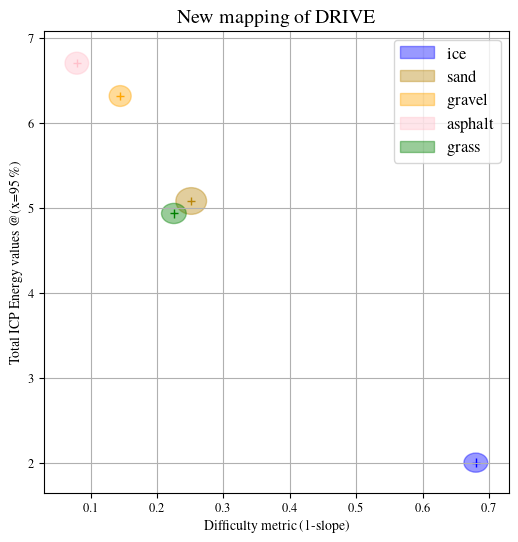

In [28]:
from matplotlib.patches import Ellipse

def plot_metric_scatter(df_res,alpha_param=0.4):

    df = df_res.copy()
    df.reset_index(inplace=True, names="terrain")

    # col = ["slope","slope_std","x_95","y_std_95"]
    x = 1- df.slope.to_numpy()
    y = df.y_95.to_numpy()

    
    
    fig, ax = plt.subplots(1,1)
    fig.set_figwidth(6)
    fig.set_figheight(6)
    fig.subplots_adjust(hspace=0.4,wspace=0.4)



    # Scatter plot the data points 
    ax.scatter(x, y, color=df.color, marker="+")

    # Plot uncertainty ellipses around each data point
    for i in range(len(x)):
        # Covariance matrix for the uncertainty (example: variance in x and y)
        
        cov = np.array([[df.slope_std.loc[i]**2, 0], [0, df.y_std_95.loc[i]**2]])  # Example covariance matrix, adjust as needed

        # Create an ellipse
        eigvals, eigvecs = np.linalg.eigh(cov)  # Eigenvalues (size of axes) and eigenvectors (orientation)
        angle = np.arctan2(*eigvecs[:, 0][::-1])  # Angle of rotation for the ellipse
        width, height = 2 * np.sqrt(eigvals)  # Width and height (2 * std dev, i.e., 95% confidence ellipse)
        
        # Create an Ellipse object
        ellipse = Ellipse((x[i], y[i]), width, height, angle=np.degrees(angle), 
                        edgecolor=df.color.loc[i], facecolor=df.color.loc[i], linestyle='-',
                        label= df.label.loc[i],alpha = alpha_param)
        
        # Add the ellipse to the plot
        plt.gca().add_patch(ellipse)


    # Add labels and legend
    ax.set_xlabel("Difficulty metric (1-slope)")
    ax.set_ylabel("Total ICP Energy values @(x=95 \%) ")
    ax.set_title('New mapping of DRIVE')
    ax.legend()
    ax.grid(True)

plot_metric_scatter(df_to_plot_metric)

In [6]:
terrain = "ice"
df_energy_wheel = KineticEnergyWheelOnly.loc[KineticEnergyWheelOnly.terrain==terrain]
        
        
rotationnal_wheel = np.mean(column_type_extractor(df_energy_wheel,"rotationnal_energy_metric"),axis=1)
translationnal_wheel = np.mean(column_type_extractor(df_energy_wheel,"translationnal_energy_metric"),axis=1)
total_energy_wheel = np.mean(column_type_extractor(df_energy_wheel,"total_energy_metric"),axis=1)

df_energy_icp  = KineticEnergyICPOnly.loc[KineticEnergyICPOnly.terrain==terrain]
rotationnal_icp_en = np.mean(column_type_extractor(df_energy_icp,"rotationnal_energy_metric"),axis=1)
translationnal_icp_en = np.mean(column_type_extractor(df_energy_icp,"translationnal_energy_metric"),axis=1)
total_energy_icp_en = np.mean(column_type_extractor(df_energy_icp,"total_energy_metric"),axis=1)




In [10]:

def find_closest_95_percentage_value(x):
    
    test =1 

test = np.linspace(0,100,21)
print(np.percentile(test,95))

find_closest_95_percentage_value(test)


95.0


In [7]:
print(popt)
print(pcov)

NameError: name 'popt' is not defined

In [ ]:
df = pd.read_pickle("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_slip_dataset.pkl")


__________ Unique columns __________
['terrain' 'robot' 'traction' 'cmd_left_wheels' 'cmd_right_wheels'
 'cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'icp_vel_x_smoothed'
 'icp_vel_yaw_smoothed' 'odom_speed_left_wheels' 'odom_speed_right_wheels'
 'slip_body_x_ss' 'slip_body_yaw_ss' 'slip_body_y_ss' 'slip_wheel_left_ss'
 'slip_wheel_right_ss' 'slip_rel_body_x_ss' 'slip_rel_body_yaw_ss'
 'slip_rel_wheel_left_ss' 'slip_rel_wheel_right_ss' 'left_wheel_vel_gains'
 'left_wheel_vel_time_constants' 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'left_wheel_vel_operation_points' 'left_wheel_vel_steps'
 'left_wheel_vel_time_for_63_percent_ss_value'
 'left_wheel_vel_time_for_86_percent_ss_value'
 'left_wheel_vel_time_for_95_percent_ss_value'
 'left_wheel_vel_theoretical_acceleration' 'right_wheel_vel_gains'
 'right_wheel_vel_time_constants' 'right_wheel_vel_time_delay'
 'right_wheel_vel_time_delay_problematic_computation'
 'right_wheel_vel_operation_points' 'right_

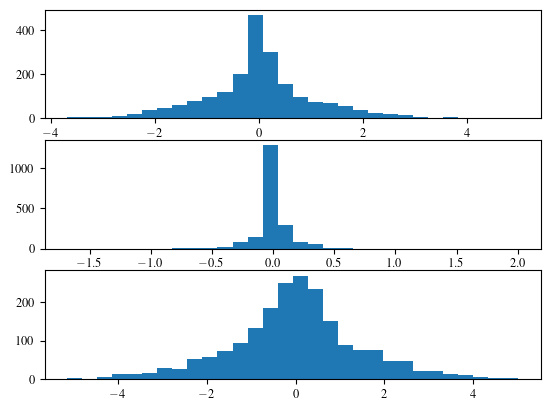

In [ ]:
df = pd.read_pickle("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl")

print_column_unique_column(df)

#df_raw = pd.read_pickle("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_slip_dataset.pkl")

list_columns = ["step_frame_vx_steps","step_frame_vy_steps","step_frame_vyaw_steps"]
delta_t_theroetical = 2 # s

list_results = []


fig, axs  = plt.subplots(3,1)

for i,col in enumerate(list_columns):
    list_results.append(column_type_extractor(df,col)/delta_t_theroetical)
    
    axs[i].hist(list_results[i],bins=30)





# Compute test the correlation for different terrain

In [ ]:


steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl"
df_diamond = pd.read_pickle(steady_state_path)


df_warthog = df_diamond.loc[df_diamond["robot"]=="warthog"]

df_sampling_speed = df_warthog.loc[df_warthog["max_linear_speed_sampled"]==5.0]

print_column_unique_column(df_sampling_speed)

list_slip_columns = ['slip_body_x_ss','slip_body_y_ss','slip_body_yaw_ss']



__________ Unique columns __________
['terrain' 'robot' 'traction' 'cmd_left_wheels' 'cmd_right_wheels'
 'cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'icp_vel_x_smoothed'
 'icp_vel_yaw_smoothed' 'odom_speed_left_wheels' 'odom_speed_right_wheels'
 'slip_body_x_ss' 'slip_body_yaw_ss' 'slip_body_y_ss' 'slip_wheel_left_ss'
 'slip_wheel_right_ss' 'slip_rel_body_x_ss' 'slip_rel_body_yaw_ss'
 'slip_rel_wheel_left_ss' 'slip_rel_wheel_right_ss' 'left_wheel_vel_gains'
 'left_wheel_vel_time_constants' 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'left_wheel_vel_operation_points' 'left_wheel_vel_steps'
 'left_wheel_vel_time_for_63_percent_ss_value'
 'left_wheel_vel_time_for_86_percent_ss_value'
 'left_wheel_vel_time_for_95_percent_ss_value'
 'left_wheel_vel_theoretical_acceleration' 'right_wheel_vel_gains'
 'right_wheel_vel_time_constants' 'right_wheel_vel_time_delay'
 'right_wheel_vel_time_delay_problematic_computation'
 'right_wheel_vel_operation_points' 'right_

__________ Unique columns __________
['terrain' 'robot' 'traction' 'cmd_left_wheels' 'cmd_right_wheels'
 'cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'icp_vel_x_smoothed'
 'icp_vel_yaw_smoothed' 'odom_speed_left_wheels' 'odom_speed_right_wheels'
 'slip_body_x_ss' 'slip_body_yaw_ss' 'slip_body_y_ss' 'slip_wheel_left_ss'
 'slip_wheel_right_ss' 'slip_rel_body_x_ss' 'slip_rel_body_yaw_ss'
 'slip_rel_wheel_left_ss' 'slip_rel_wheel_right_ss' 'left_wheel_vel_gains'
 'left_wheel_vel_time_constants' 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'left_wheel_vel_operation_points' 'left_wheel_vel_steps'
 'left_wheel_vel_time_for_63_percent_ss_value'
 'left_wheel_vel_time_for_86_percent_ss_value'
 'left_wheel_vel_time_for_95_percent_ss_value'
 'left_wheel_vel_theoretical_acceleration' 'right_wheel_vel_gains'
 'right_wheel_vel_time_constants' 'right_wheel_vel_time_delay'
 'right_wheel_vel_time_delay_problematic_computation'
 'right_wheel_vel_operation_points' 'right_

KeyError: 'sand'

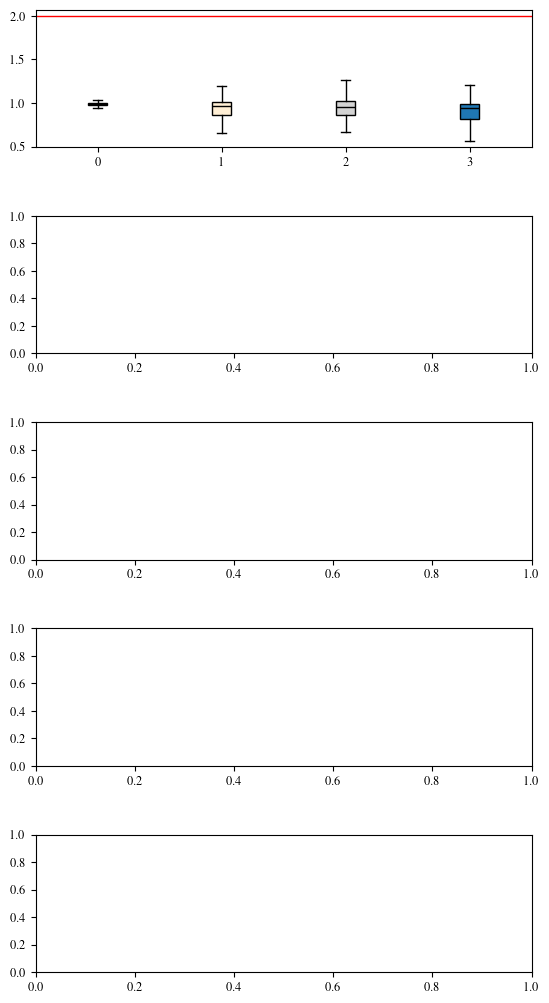

In [ ]:


steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl"
df_diamond = pd.read_pickle(steady_state_path)

print_column_unique_column(df_diamond)


def graph_boxplot_by_terrain(ax,df_diamond,col_interest,label_y,color_dict):

    list_terrain = sorted((df_diamond["terrain"].unique())) # alphabetical
    size = len(list_terrain)
    #box_plot(df_diamond,axs[0,0],"allo")
    median_by_terrain = df_diamond.groupby('terrain')[col_interest].median().reset_index()
    median_by_terrain_sorted  = median_by_terrain.sort_values(by=col_interest, ascending=False).reset_index().terrain
    
    

    list_position = [i for i in range(size)]
    ax.axhline(2,min(list_position),max(list_position),color="red")
    list_boxplot = []
    for i in range(size):
        terrain = median_by_terrain_sorted[i]
        df = df_diamond.loc[df_diamond["terrain"]==terrain]
        #print(col_interest)
        box = ax.boxplot(df[col_interest].values,positions = [i],
                            boxprops=dict(color='black'),  # Box outline color
                            medianprops=dict(color='black'),  # Median line color
                            whiskerprops=dict(color='black'),  # Whiskers color
                            capprops=dict(color='black'),
                            patch_artist=True,showfliers=False)  # Caps color
                            
        list_boxplot.append(box)
        box["boxes"][0].set_facecolor(color_dict[terrain])
    ax.set_title(f"{col_interest}")
    ax.set_xticks(ticks = list_position, labels= median_by_terrain_sorted)
    ax.set_ylabel(label_y)


def boxplot_time_constant_all_speed_one_param(df,color_dict,time_constant_suffix ="time_constants",filter_out=" ",path_to_res=""):

    ####

    
    list_column = list(df.columns)
    col_to_keep = []
    for col in list_column:
        #print(col)
        if (time_constant_suffix in col) and (filter_out not in col):
            col_to_keep.append(col)
    ####
    
    fig, axs = plt.subplots(len(col_to_keep),1)
    fig.set_figheight(2.5 * len(col_to_keep))
    fig.set_figheight(2.5 * len(col_to_keep))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    label_y = "Time [s]"
    col_interest = "step_frame_vx_time_constants"

    for col_interest,ax in zip(col_to_keep,np.ravel(axs)):
       
        graph_boxplot_by_terrain(ax,df,col_interest,label_y,color_dict)
    if path_to_res != "":
        fig.savefig(path_to_res/(time_constant_suffix+".pdf"))
    return axs


def produce_all_time_constant_boxplot(df_diamond,color_dict,path_to_results):

    if isinstance(path_to_results,str):
        path_to_results = pathlib.Path(path_to_results)

    path_to_time_cst_analysis = path_to_results/"first_order_analysis"
    if path_to_time_cst_analysis.is_dir()==False:
        path_to_time_cst_analysis.mkdir()

    

    list_col_interest = ['gains','time_constants','time_delay',"_for_63_percent_ss_value",
                        "_time_for_86_percent_ss_value","_time_for_95_percent_ss_value",
                        "diff_body_wheel_time_constants","diff_body_wheel_time_delay",
                        "diff_body_wheel_time_for_86_percent_ss_value",
                        "diff_body_wheel_time_for_95_percent_ss_value",
                        'diff_body_wheel_time_for_63_percent_ss_value']
    list_col_to_filter_out = [" ","to_show","problematic", " "," "," ", " "," ", " ", " ", " "]

    print(len(list_col_interest))
    print(len(list_col_to_filter_out))
    list_axs = []
    for time_constant_suffix, filter_out in zip(list_col_interest,list_col_to_filter_out):
        list_axs.append(boxplot_time_constant_all_speed_one_param(df_diamond,color_dict,time_constant_suffix =time_constant_suffix,filter_out=filter_out,path_to_res=path_to_time_cst_analysis))
    #     'right_wheel_vel_operation_points', 'right_wheel_vel_steps',
    plt.close("all")
    ncol = len(list_axs)
    nrow = list_axs[0].shape[0]
    fig, axs = plt.subplots(nrow,ncol)

    scale_factor = 3
    fig.set_figheight(nrow*scale_factor)
    fig.set_figwidth(ncol*scale_factor)

    #for i in range(ncol):
    #    print(nrow)
    #    axs[:,i] = list_axs[i]

    #fig.savefig("/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/analysis/test_time_constant")

#boxplot_time_constant_all_speed_one_param(df_diamond,color_dict,time_constant_suffix ="time_constants",filter_out="to_show")

df_sampling_speed = df_diamond.loc[df_diamond["max_linear_speed_sampled"]==5.0]

df_diamond_roboticist_dom = df_sampling_speed.loc[df_sampling_speed["roboticist"]=="dominicbaril"]

df_diamond_roboticist_dom = df_sampling_speed.loc[df_sampling_speed["roboticist"]=="nicolassamson"]
produce_all_time_constant_boxplot(df_sampling_speed,color_dict,path_to_results="/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe")

In [ ]:
for ordered_i in median_order:
    print(median_by_terrain_sorted.loc[ordered_i])
    terrain = list_terrain[ordered_i]
    df = df_diamond.loc[df_diamond["terrain"]==terrain]
    box = ax.boxplot(df[col_interest].values,positions = [list_position[ordered_i]],
                        boxprops=dict(color='black'),  # Box outline color
                          medianprops=dict(color='black'),  # Median line color
                          whiskerprops=dict(color='black'),  # Whiskers color
                          capprops=dict(color='black'),
                          patch_artist=True,showfliers=False)  # Caps color
                        
    list_boxplot.append(box)
    box["boxes"][0].set_facecolor(color_dict[terrain])


/tmp/ipykernel_5393/2746649452.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_diamond[sorting_name] = df_diamond["terrain"].replace(median_by_terrain)


TypeError: 'Axes' object is not subscriptable

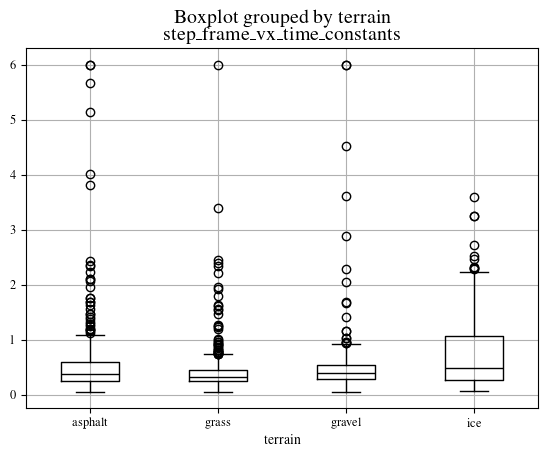

In [ ]:
# Sorted the values 
# Compute the median values for each terrain and sort them
median_values = df_diamond.groupby('terrain')[col_interest].median().sort_values()
sorted_terrains = median_values.index
df_diamond['terrain_argsort'] = df_diamond['terrain'].argsort()

# Create filter  
median_by_terrain = df_diamond.groupby('terrain')[col_interest].median()

sorting_name = "median_by"+col_interest
df_diamond[sorting_name] = df_diamond["terrain"].replace(median_by_terrain)
df_diamond.sort_values(sorting_name,inplace=True)

# Convert the 'terrain' column to a categorical type with the specified order
#df_diamond['terrain'] = pd.Categorical(df_diamond['terrain'], categories=median_by_terrain, ordered=True)

box = df_diamond.boxplot(column=col_interest, by='terrain', 
                          boxprops=dict(color='black'),  # Box outline color
                          medianprops=dict(color='black'),  # Median line color
                          whiskerprops=dict(color='black'),  # Whiskers color
                          capprops=dict(color='black'))  # Caps color

# Iterate through each box and set the face color
for i, terrain in enumerate(df_diamond['terrain'].unique()):
    box['boxes'][i].set_facecolor(color_dict[terrain])


$$
Time2SteadyState= Tss
\newline
diff_{Tss} =max( Vx_{Tss},Vyaw_{Tss}) -  max( \omega L_{Tss},\omega R_{Tss})
$$

In [ ]:
path_to_dataset = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/slip_dataset_all.pkl"
df = pd.read_pickle(path_to_dataset)
imu_acceleration_x = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=False)
imu_acceleration_x_transient = column_type_extractor(df,"imu_acceleration_x",verbose=False,steady_state=True)
steady_state_path = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/data/warthog/wheels/asphalt/warthog_wheels_asphalt_2024_9_20_8h21s48/model_training_datasets/steady_state_results.pkl"
df_diamond = pd.read_pickle(steady_state_path)
print_column_unique_column(df_diamond)






['cmd_body_x_lwmean' 'cmd_body_yaw_lwmean' 'cmd_left_wheels'
 'cmd_right_wheels' 'icp_vel_x_smoothed' 'icp_vel_yaw_smoothed'
 'left_wheel_vel_gains' 'left_wheel_vel_operation_points'
 'left_wheel_vel_predictions' 'left_wheel_vel_steps'
 'left_wheel_vel_time_constants' 'left_wheel_vel_time_constants_to_show'
 'left_wheel_vel_time_delay'
 'left_wheel_vel_time_delay_problematic_computation'
 'odom_speed_left_wheels' 'odom_speed_right_wheels'
 'right_wheel_vel_gains' 'right_wheel_vel_operation_points'
 'right_wheel_vel_predictions' 'right_wheel_vel_steps'
 'right_wheel_vel_time_constants' 'right_wheel_vel_time_constants_to_show'
 'right_wheel_vel_time_delay'
 'right_wheel_vel_time_delay_problematic_computation' 'robot'
 'slip_body_x_ss' 'slip_body_y_ss' 'slip_body_yaw_ss' 'slip_wheel_left_ss'
 'slip_wheel_right_ss' 'step_frame_vx_gains'
 'step_frame_vx_operation_points' 'step_frame_vx_predictions'
 'step_frame_vx_steps' 'step_frame_vx_time_constants'
 'step_frame_vx_time_constants_to_show'

array(['cmd_body_x_lwmean', 'cmd_body_yaw_lwmean', 'cmd_left_wheels',
       'cmd_right_wheels', 'icp_vel_x_smoothed', 'icp_vel_yaw_smoothed',
       'left_wheel_vel_gains', 'left_wheel_vel_operation_points',
       'left_wheel_vel_predictions', 'left_wheel_vel_steps',
       'left_wheel_vel_time_constants',
       'left_wheel_vel_time_constants_to_show',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_delay_problematic_computation',
       'odom_speed_left_wheels', 'odom_speed_right_wheels',
       'right_wheel_vel_gains', 'right_wheel_vel_operation_points',
       'right_wheel_vel_predictions', 'right_wheel_vel_steps',
       'right_wheel_vel_time_constants',
       'right_wheel_vel_time_constants_to_show',
       'right_wheel_vel_time_delay',
       'right_wheel_vel_time_delay_problematic_computation', 'robot',
       'slip_body_x_ss', 'slip_body_y_ss', 'slip_body_yaw_ss',
       'slip_wheel_left_ss', 'slip_wheel_right_ss', 'step_frame_vx_gains',
       'step_frame_v

In [ ]:
list_names = ['cmd_body_x_lwmean', 'cmd_body_yaw_lwmean', 'cmd_left_wheels',
       'cmd_right_wheels', 'icp_vel_x_smoothed', 'icp_vel_yaw_smoothed',
       'left_wheel_vel_gains', 'left_wheel_vel_operation_points',
       'left_wheel_vel_predictions', 'left_wheel_vel_steps',
       'left_wheel_vel_time_constants',
       'left_wheel_vel_time_constants_to_show',
       'left_wheel_vel_time_delay',
       'left_wheel_vel_time_delay_problematic_computation',
       'odom_speed_left_wheels', 'odom_speed_right_wheels',
       'right_wheel_vel_gains', 'right_wheel_vel_operation_points',
       'right_wheel_vel_predictions', 'right_wheel_vel_steps',
       'right_wheel_vel_time_constants',
       'right_wheel_vel_time_constants_to_show',
       'right_wheel_vel_time_delay',
       'right_wheel_vel_time_delay_problematic_computation', 'robot',
       'slip_body_x_ss', 'slip_body_y_ss', 'slip_body_yaw_ss',
       'slip_wheel_left_ss', 'slip_wheel_right_ss', 'step_frame_vx_gains',
       'step_frame_vx_operation_points', 'step_frame_vx_predictions',
       'step_frame_vx_steps', 'step_frame_vx_time_constants',
       'step_frame_vx_time_constants_to_show', 'step_frame_vx_time_delay',
       'step_frame_vx_time_delay_problematic_computation',
       'step_frame_vy_gains', 'step_frame_vy_operation_points',
       'step_frame_vy_predictions', 'step_frame_vy_steps',
       'step_frame_vy_time_constants',
       'step_frame_vy_time_constants_to_show', 'step_frame_vy_time_delay',
       'step_frame_vy_time_delay_problematic_computation',
       'step_frame_vyaw_gains', 'step_frame_vyaw_operation_points',
       'step_frame_vyaw_predictions', 'step_frame_vyaw_steps',
       'step_frame_vyaw_time_constants',
       'step_frame_vyaw_time_constants_to_show',
       'step_frame_vyaw_time_delay',
       'step_frame_vyaw_time_delay_problematic_computation', 'terrain',
       'traction']

print("[")
for names in list_names:
    
    if "_steps" in names and "to_show" not in names :
        print(f"'{names}',")


[
'left_wheel_vel_steps',
'right_wheel_vel_steps',
'step_frame_vx_steps',
'step_frame_vy_steps',
'step_frame_vyaw_steps',


In [ ]:


def plot_histogramme(ax,df,column_of_interest,transient_only_flag=True,nb_bins=30,range=(0,0)):


    if transient_only_flag:
        imu_acceleration_x = column_type_extractor(df,column_of_interest,verbose=False,steady_state=False)
        labels_y = column_of_interest+"\n transient_state"
    
    else:
        imu_acceleration_x= column_type_extractor(df,column_of_interest,verbose=False,steady_state=True)
        labels_y = column_of_interest

    
    if range == (0,0):
            ax.hist(imu_acceleration_x,bins=nb_bins)
    else:
            ax.hist(imu_acceleration_x,bins=nb_bins,range=range)


    
    ax.set_xlabel(labels_y)
    
def global_y_axis(axs):
    
    flatten_axs = np.ravel(axs)
    
    min = 0 
    max = 0
    for ax in flatten_axs:
        if ax.get_ylim()[1]> max:
            max =  ax.get_ylim()[1]

    for ax in flatten_axs:
        ax.set_ylim(min,max)


def plot_all(df,list_of_column_of_interest,nb_bins=25,range=(0,0)):

    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    
    for ax,column_of_interest in zip(axs,list_of_column_of_interest):

        plot_histogramme(ax,df,column_of_interest,nb_bins=nb_bins,range=range)


    global_y_axis(axs)

    return fig

def plot_diamond_hist(df, list_of_column_of_interest,nb_bins=25, range=(0,0)): 
    test = ["icp_vel_x_gains","icp_vel_y_gains","icp_vel_yaw_gains","left_wheel_vel_gains","right_wheel_vel_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    return fig

In [ ]:
# Descriptions 

def plot_acceleration_histogramme(df,nb_bins=30,range=(0,0)):
    

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    df = df
    
    fig, axs = plt.subplots(1,3)
    fig.set_figwidth(3*len(list_of_column_of_interest))
    

    plot_all(axs,df,list_of_column_of_interest,nb_bins=30,range=range)


def plot_slip_histogramme(df,nb_bins=30,range=(0,0)):
    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    df = df
    fig.set_figwidth(3*len(axs))

    plot_all(axs,df,list_of_column_of_interest,nb_bins=nb_bins,range=range)

def plot_steps_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = ["step_frame_vx","step_frame_vy","step_frame_vy"]
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)
    
        axs[i].set_xlabel(column_of_interest)
    
    global_y_axis(axs)
def plot_operation_histogramme(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,3)

    list_of_column_of_interest = [
    'left_wheel_vel_operation_points',
    'right_wheel_vel_operation_points',
    'step_frame_vx_operation_points',
    'step_frame_vy_operation_points',
    'step_frame_vyaw_operation_points']
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            axs[i].set_xlabel(column_of_interest)
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
def plot_time_constant(df,nb_bins=30,range=(0,0)):

    fig, axs = plt.subplots(1,5)

    list_of_column_of_interest = [
    'left_wheel_vel_time_constants',
    'right_wheel_vel_time_constants',
    'step_frame_vx_time_constants',
    'step_frame_vy_time_constants',
    'step_frame_vyaw_time_constants']
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):
        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)

        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)
        
def plot_proportionnal_slip(df,nb_bins=30,range=(0,0),name=""):
    list_of_column_of_interest = ["left_wheel_vel_gains","right_wheel_vel_gains","step_frame_vx_gains","step_frame_vy_gains","step_frame_vyaw_gains"]
    fig, axs = plt.subplots(1,len(list_of_column_of_interest))
    df = df
    fig.set_figwidth(3*len(axs))

    for i,column_of_interest in enumerate(list_of_column_of_interest):

        if range == (0,0):
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins)
            
        else:
            axs[i].hist(df[list_of_column_of_interest[i]],bins=nb_bins,range=range)



        axs[i].set_xlabel(column_of_interest)
    global_y_axis(axs)

    # Save the figure using pickle
    #with open(name, 'wb') as f:
    #    pickle.dump(fig, f)

    



def plot_all_histogramme(df, df_diamond,path_to_results):

    name = "diamond_hist.pkl"

    list_fig = []
    list_of_column_of_interest = [
    'left_wheel_vel_steps',
    'right_wheel_vel_steps',
    'step_frame_vx_steps',
    'step_frame_vy_steps',
    'step_frame_vyaw_steps']
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=20,range= (-10,10)))

    list_of_column_of_interest = [
    'left_wheel_vel_operation_points',
    'right_wheel_vel_operation_points',
    'step_frame_vx_operation_points',
    'step_frame_vy_operation_points',
    'step_frame_vyaw_operation_points']
    
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    list_of_column_of_interest =[
    'left_wheel_vel_time_constants',
    'right_wheel_vel_time_constants',
    'step_frame_vx_time_constants',
    'step_frame_vy_time_constants',
    'step_frame_vyaw_time_constants']

    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(0,6)))


    list_of_column_of_interest = ["left_wheel_vel_gains","right_wheel_vel_gains","step_frame_vx_gains","step_frame_vy_gains","step_frame_vyaw_gains"]
    list_fig.append(plot_diamond_hist(df_diamond, list_of_column_of_interest,nb_bins=30, range=(-5,5)))

    list_of_column_of_interest = ["imu_acceleration_x","imu_acceleration_y","imu_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=20,range=(-5,5)))

    list_of_column_of_interest = ["body_vel_disturption_x","body_vel_disturption_y","body_vel_disturption_yaw"]
    list_fig.append(plot_all(df,list_of_column_of_interest,nb_bins=30,range= (-5,5)))

    path_to_pdf = path_to_results/"histogramme_analysis.pdf"
    # Create a PDF file to save the figures
    with PdfPages(str(path_to_pdf)) as pdf:

        for figure in list_fig:
            pdf.savefig(figure)
            

    #plot_acceleration_histogramme(df)
    #plot_slip_histogramme(df,nb_bins=30,range= (-5,5))

    
    #plot_steps_histogramme(df_diamond,nb_bins=20,range= (-10,10))
    #plot_operation_histogramme(df_diamond,nb_bins=30,range= (-5,5))
    #plot_time_constant(df_diamond,nb_bins=30,range= (0,6))
    #plot_proportionnal_slip(df_diamond,nb_bins=30,range= (-5,5))



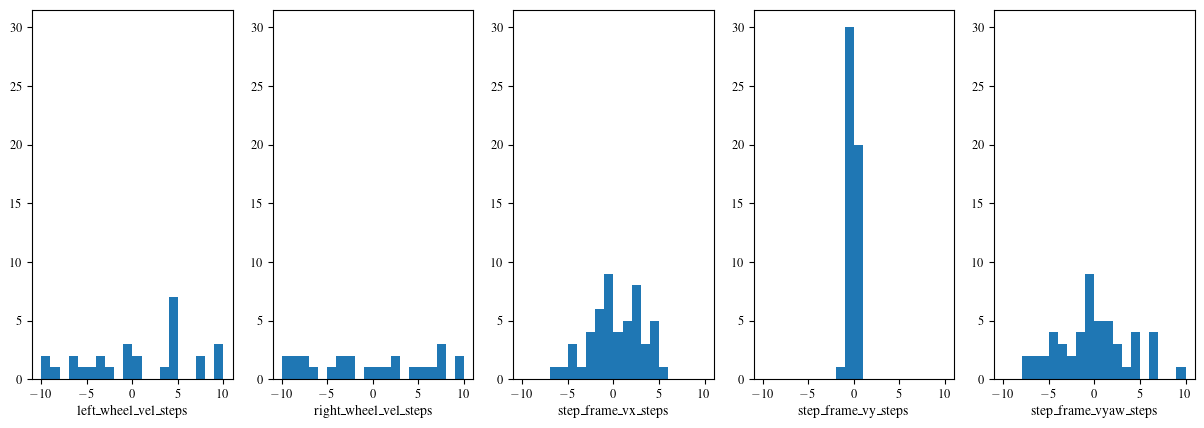

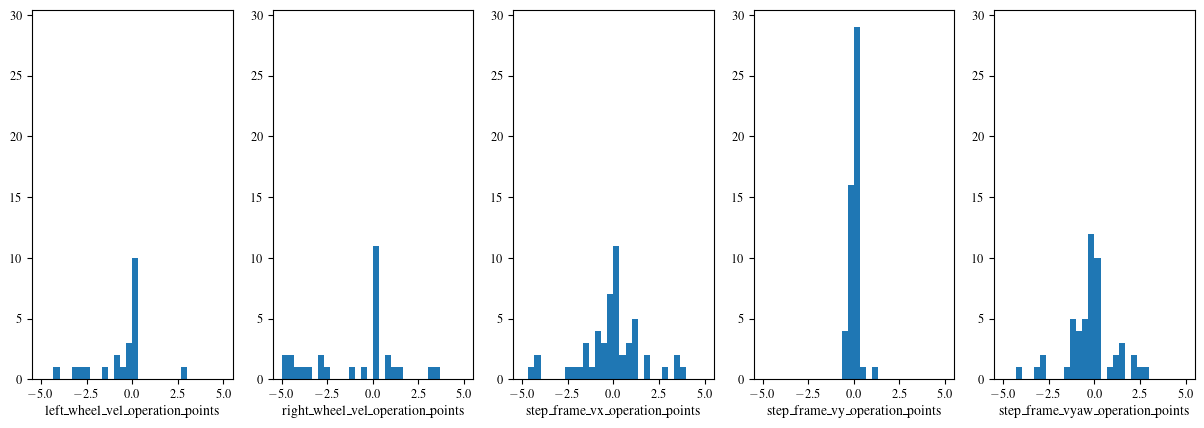

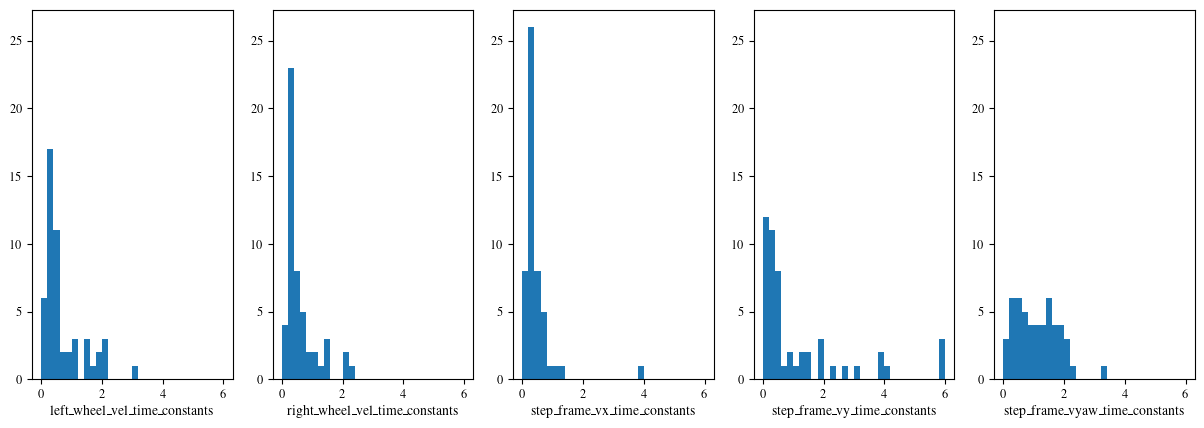

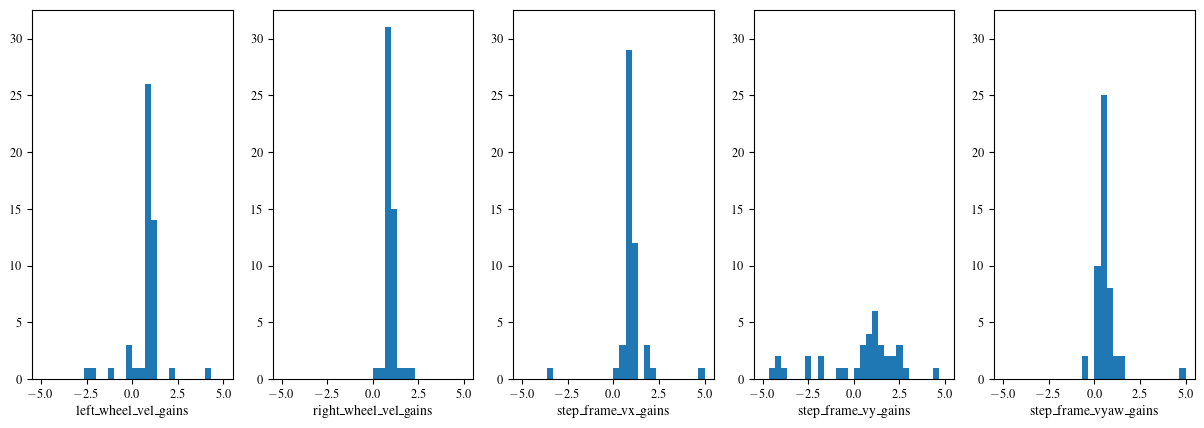

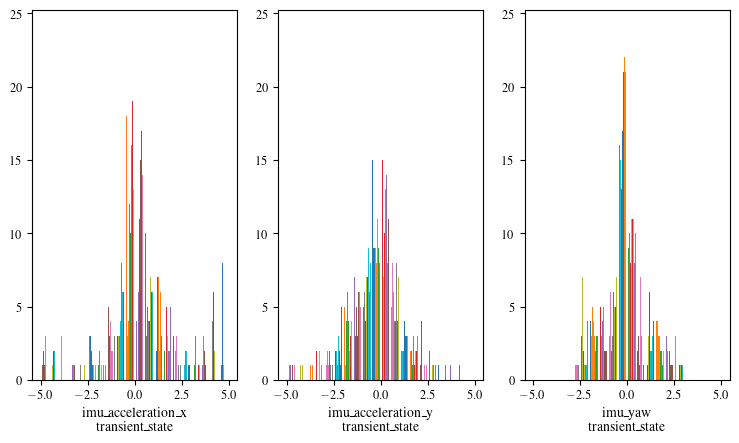

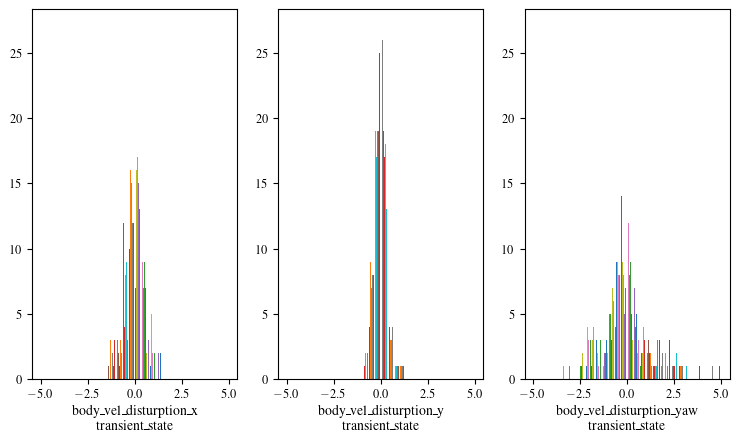

In [ ]:
path_slip_dataset = pathlib.Path(path_to_dataset)
path_to_results = path_slip_dataset.parent.parent /"results"

if path_to_results.is_dir() == False:
    path_to_results.mkdir()

plot_all_histogramme(df, df_diamond,path_to_results)


In [ ]:
from graph_module import *
path_to_df_slip = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_slip_dataset.pkl"
path_to_df_steady = "/home/nicolassamson/ros2_ws/src/DRIVE/drive_datasets/results_multiple_terrain_dataframe/all_terrain_steady_state_dataset.pkl"
producer = GraphicProductionDrive(path_to_df_slip,path_to_df_steady)
producer.produce_slip_histogramme_by_roboticist_for_a_specific_linear_sampling_speed(robiticis_specific=False)



test
test2
Note that the yaw angle in the the smooth version is the IMU
Note that the yaw angle in the the smooth version is the IMU
Note that the yaw angle in the the smooth version is the IMU


In [ ]:
def box_plot(df, ax, column_of_interest):

        text = "step_frame_vx_time_constants_to_show"
        
        list_terrain = list(df["terrain"].unique())
        size = len(list_terrain)

        print(df.groupby("terrain")[text].describe())
        # 1. Find all the sub dataframe and compute median 

        # 2. Reorder them by median  
        
        # 3. Boxplot them by order of median 

        # 4. 